# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

# # 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# drive.mount('/content/drive')

# # 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
# !tar -xvf drive/MyDrive/datasets_fin.tar > /dev/null

In [3]:
# 필요한 라이브러리를 설치합니다.
%pip install timm

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [1]:
import os
import time
import random

import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [10]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, csv, path, transform=None):
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, int(target)

In [11]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        preds = model(image)
        loss = loss_fn(preds, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [12]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = 'data/'

# model config
model_name = 'resnet50' # 'resnet50' 'efficientnet-b0', ...# vgg16

# training config
img_size = 256
LR = 1e-3
EPOCHS = 30
BATCH_SIZE = 32
num_workers = 0

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [13]:
# augmentation을 위한 transform 코드
trn_transform = A.Compose([
    # 이미지 크기 조정
    A.Resize(height=img_size, width=img_size),
    # images normalization
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # numpy 이미지나 PIL 이미지를 PyTorch 텐서로 변환
    ToTensorV2(),
])

# test image 변환을 위한 transform 코드
tst_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [ ]:
# Dataset 정의
# trn_dataset = ImageDataset(
#     "data/train.csv",
#     "data/train_2/",
#     transform=trn_transform
# )
tst_dataset = ImageDataset(
    "data/sample_submission.csv",
    "data/test/",
    transform=tst_transform
)
print(len(tst_dataset)) # len(trn_dataset),

1570 3140


In [ ]:
# DataLoader 정의
# trn_loader = DataLoader(
#     trn_dataset,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=num_workers,
#     pin_memory=True,
#     drop_last=False
# )
tst_loader = DataLoader(
    tst_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [78]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
from sklearn.preprocessing import LabelEncoder

# Define the number of splits
n_splits = 5  # You can adjust the number of splits as needed

# Define StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define dataset and loaders
dataset = ImageDataset("data/train.csv", "data/train_2/", transform=trn_transform)
label_encoder = LabelEncoder()

# Dictionary to store results
results = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": []
}

# Iterate through folds
X = dataset.df[:,0]  # 이미지 데이터
y = dataset.df[:,1]  # 타겟 데이터
y = y.astype(int)
# ValueError: Supported target types are: ('binary', 'multiclass'). Got 'unknown' instead.
#y = label_encoder.fit_transform(y) # label encoder 안해주면, error나옴

In [79]:
for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # Split data into train and validation sets
    train_dataset = Subset(dataset, train_index)
    valid_dataset = Subset(dataset, valid_index)

    # DataLoader 정의
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )

    # Initialize model for each fold
    model = timm.create_model(
        model_name,
        pretrained=True,
        num_classes=17
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=LR)

    # Train the model for each fold
    for epoch in range(EPOCHS): #EPOCHS
        print(f"Epoch {epoch + 1}/{EPOCHS}")

        # Train one epoch
        train_ret = train_one_epoch(train_loader, model, optimizer, loss_fn, device=device)

        # Log train results
        train_log = ""
        for k, v in train_ret.items():
            train_log += f"{k}: {v:.4f}\n"
        print(train_log)

        # Store train results
        results["train_loss"].append(train_ret["train_loss"])
        results["train_acc"].append(train_ret["train_acc"])
        results["train_f1"].append(train_ret["train_f1"])

# Print overall results
print("Overall Results:")
for key, value in results.items():
    print(f"{key}: {sum(value) / len(value):.4f}")

Fold 1/5
Epoch 1/30


Loss: 0.6347: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]


train_loss: 1.7818
train_acc: 0.5072
train_f1: 0.4928

Epoch 2/30


Loss: 0.5295: 100%|██████████| 40/40 [00:07<00:00,  5.05it/s]


train_loss: 0.4084
train_acc: 0.8543
train_f1: 0.8409

Fold 2/5
Epoch 1/30


Loss: 0.9502: 100%|██████████| 40/40 [00:07<00:00,  5.08it/s]


train_loss: 1.8552
train_acc: 0.5088
train_f1: 0.4666

Epoch 2/30


Loss: 0.3201: 100%|██████████| 40/40 [00:07<00:00,  5.06it/s]


train_loss: 0.4138
train_acc: 0.8662
train_f1: 0.8466

Fold 3/5
Epoch 1/30


Loss: 1.0810: 100%|██████████| 40/40 [00:07<00:00,  5.08it/s]


train_loss: 1.9083
train_acc: 0.5135
train_f1: 0.4728

Epoch 2/30


Loss: 0.5634: 100%|██████████| 40/40 [00:07<00:00,  5.04it/s]


train_loss: 0.4209
train_acc: 0.8479
train_f1: 0.8240

Fold 4/5
Epoch 1/30


Loss: 2.2137: 100%|██████████| 40/40 [00:07<00:00,  5.05it/s]


train_loss: 1.8157
train_acc: 0.5454
train_f1: 0.4778

Epoch 2/30


Loss: 0.2387:  90%|█████████ | 36/40 [00:07<00:00,  4.86it/s]


KeyboardInterrupt: 

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [24]:
import pickle
# 저장된 모델을 불러옵니다.
with open('saved_model_sanghyuk_32_rotation_10_eda_3.pkl', 'rb') as f:
    model = pickle.load(f)

In [25]:
preds_list = []

model.eval()
for image, _ in tqdm(tst_loader):
    image = image.to(device)

    with torch.no_grad():
        preds = model(image)
    preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

100%|██████████| 99/99 [00:15<00:00,  6.38it/s]


In [26]:
pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
pred_df['target'] = preds_list

In [27]:
sample_submission_df = pd.read_csv("data/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [28]:
pred_df.to_csv("./pred/pred_sangmin_6.csv", index=False)

In [ ]:
pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,6
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,16
4,00901f504008d884.jpg,2


# 모델이 학습한 부분 시각화 gray

target,class_name
0,account_number
1,application_for_payment_of_pregnancy_medical_expenses
2,car_dashboard
3,confirmation_of_admission_and_discharge
4,diagnosis
5,driver_lisence
6,medical_bill_receipts
7,medical_outpatient_certificate
8,national_id_card
9,passport
10,payment_confirmation
11,pharmaceutical_receipt
12,prescription
13,resume
14,statement_of_opinion
15,vehicle_registration_certificate
16,vehicle_registration_plate


In [11]:
import pickle
# 저장된 모델을 불러옵니다.
with open('saved_model_rotation_10.pkl', 'rb') as f:
    model = pickle.load(f)

In [12]:
trn_dataset = ImageDataset(
    "data/split_train.csv",
    "data/split_train_data/",
    transform=trn_transform
)

In [13]:
from PIL import Image
from torchvision import transforms 


class SaveOutput:
    def __init__(self):
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        
    def clear(self):
        self.outputs = []
save_output = SaveOutput()


def one_image_visual(model, image_number, trn_data_set):
    hook_handles = []
    for layer in list(model.modules()):
        # 레이어가 torch,nn.modules.conv.Conv2d() 일때만 걸어준다. 
        if isinstance(layer, torch.nn.modules.conv.Conv2d):
            handle = layer.register_forward_hook(save_output) # forward 진행시마다 save_output 실행 
            hook_handles.append(handle)


    transform = transforms.Compose([ToTensorV2()])
    dtype = torch.float32 
    X = trn_dataset[image_number] # 이미지 한장, 100번째 이미지 

    one_image = X[0].unsqueeze(dim=0).to(device) 
    one_image = one_image.to(device=device, dtype=dtype)
    #print(type(one_image), one_image.shape)

    out=model(one_image) # 모델에 데이터를 저장할때, 
    return out

In [14]:
class_names = {
    0: 'account_number',
    1: 'application_for_payment_of_pregnancy_medical_expenses',
    2: 'car_dashboard',
    3: 'confirmation_of_admission_and_discharge',
    4: 'diagnosis',
    5: 'driver_lisence',
    6: 'medical_bill_receipts',
    7: 'medical_outpatient_certificate',
    8: 'national_id_card',
    9: 'passport',
    10: 'payment_confirmation',
    11: 'pharmaceutical_receipt',
    12: 'prescription',
    13: 'resume',
    14: 'statement_of_opinion',
    15: 'vehicle_registration_certificate',
    16: 'vehicle_registration_plate'
}


save_output = SaveOutput()
IMAGE_NUMBER = 3400
one_image = trn_dataset[IMAGE_NUMBER]
pred = one_image_visual(model, IMAGE_NUMBER, trn_data_set=trn_dataset)

# 예측 결과 출력
target_number = one_image[1]
predicted_number = np.argmax(pred.cpu().detach().numpy())


print(f"현재 이미지 값: {target_number}, 예측한 넘버 : {predicted_number}")
print(f"현재 이미지 : {class_names[target_number]}, 모델이 예측한 것 : {class_names[predicted_number]}")

현재 이미지 값: 1, 예측한 넘버 : 11
현재 이미지 : application_for_payment_of_pregnancy_medical_expenses, 모델이 예측한 것 : pharmaceutical_receipt


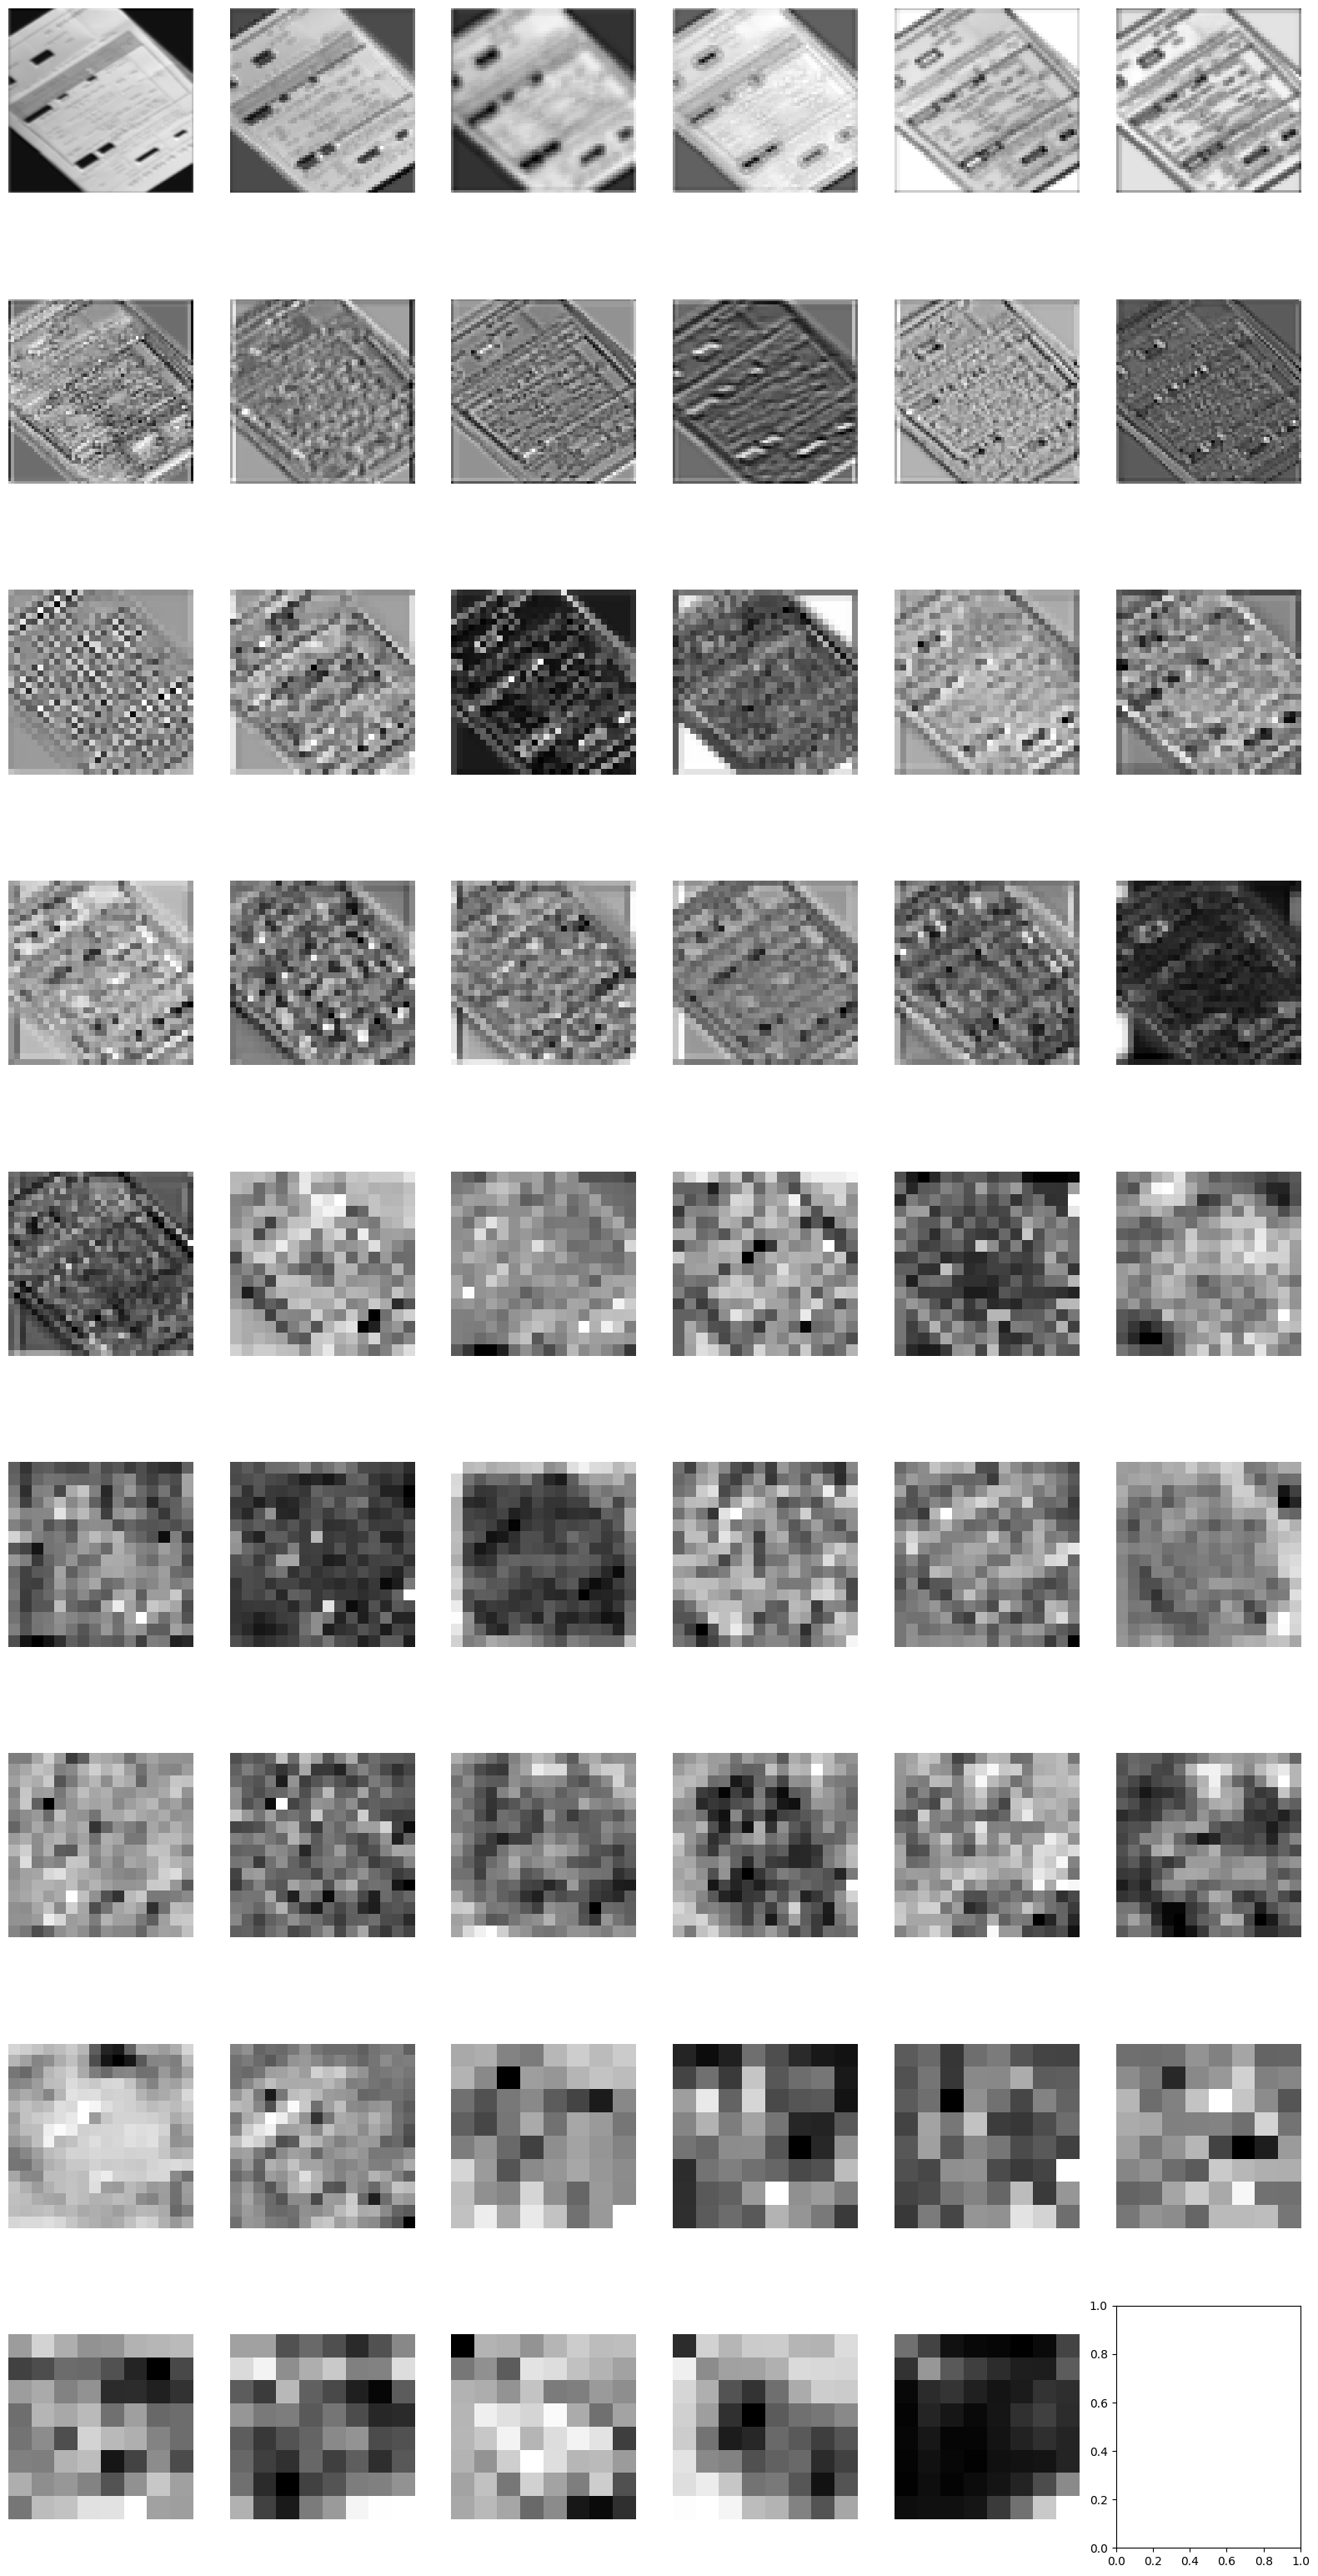

In [15]:
import matplotlib.pyplot as plt

MAX_IMAGES_PER_ROW = 6 # 한 행에 출력할 수 있는 최대 이미지 수
total_images = len(save_output.outputs)
num_rows = int((total_images-1) / MAX_IMAGES_PER_ROW) + 1  # 이미지 개수에 맞게 행 개수를 계산합니다.
num_cols = min(total_images, MAX_IMAGES_PER_ROW)  # 최대 6개의 열로 설정합니다.
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 40))

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * MAX_IMAGES_PER_ROW + j
        if idx < total_images:
            img = save_output.outputs[idx][0][0]# / 2 + 0.5 # 정규화 함.
            img = img.cpu().detach().numpy()
            axes[i, j].imshow(img, cmap='gray') # gray, viridis color_maps = ['gray', 'viridis', 'cividis', 'plasma', 'inferno', 'magma', 'jet']
            axes[i, j].axis('off')
        else:
            break

plt.show()

# confusion_matrix

In [16]:
# val image 변환을 위한 transform 코드
val_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [17]:
# val _ data만듬
val_dataset = ImageDataset(
    "data/split_val.csv",
    "data/split_val_data/",
    transform = val_transform
)

In [18]:
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False
)

In [19]:
# confusion_matrix

from sklearn import metrics
import matplotlib.pyplot as plt

import pickle
# 저장된 모델을 불러옵니다.
with open('saved_model_rotation_10.pkl', 'rb') as f:
    model = pickle.load(f)

model = model.to(device)
model.eval()

y_pred = []
y_true = []

class_names = {
    0: 'account_number',
    1: 'application_for_payment_of_pregnancy_medical_expenses',
    2: 'car_dashboard',
    3: 'confirmation_of_admission_and_discharge',
    4: 'diagnosis',
    5: 'driver_lisence',
    6: 'medical_bill_receipts',
    7: 'medical_outpatient_certificate',
    8: 'national_id_card',
    9: 'passport',
    10: 'payment_confirmation',
    11: 'pharmaceutical_receipt',
    12: 'prescription',
    13: 'resume',
    14: 'statement_of_opinion',
    15: 'vehicle_registration_certificate',
    16: 'vehicle_registration_plate'
}

for batch in tqdm(val_loader):
    with torch.no_grad():
        inputs, targets = batch

        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].detach().cpu().numpy())
    y_true.extend(targets.detach().cpu().numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3) # digits 소수점 3자리
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

print(f"perfomance \n {performance}")

100%|██████████| 364/364 [00:47<00:00,  7.70it/s]

perfomance 
               precision    recall  f1-score   support

           0      1.000     1.000     1.000       740
           1      1.000     1.000     1.000       340
           2      1.000     1.000     1.000       740
           3      1.000     1.000     1.000       740
           4      1.000     1.000     1.000       740
           5      1.000     1.000     1.000       740
           6      1.000     1.000     1.000       740
           7      1.000     1.000     1.000       740
           8      1.000     1.000     1.000       740
           9      1.000     1.000     1.000       740
          10      1.000     1.000     1.000       740
          11      1.000     1.000     1.000       740
          12      1.000     1.000     1.000       740
          13      1.000     1.000     1.000       547
          14      1.000     1.000     1.000       370
          15      1.000     1.000     1.000       740
          16      1.000     1.000     1.000       740

    accuracy 

In [ ]:
display_confusionmap = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=list(range(len(class_names))))

display_confusionmap.plot()
fig = display_confusionmap.ax_.get_figure()
fig.set_figwidth(len(class_names))
fig.set_figheight(len(class_names))
plt.savefig("validation_confusion_metrix.jpg") # 그림 저장
plt.show

총 7개에서 모델 학습시 영향이 큰 경향 
       precision    recall  f1-score   support
1번 : 1: 'application_for_payment_of_pregnancy_medical_expenses', 임산부 신청서 
1      0.976     1.000     0.988      1343
3번 : 3: 'confirmation_of_admission_and_discharge', 입퇴원 확인서
 3      0.767     0.901     0.829      2920
4번 : 4: 'diagnosis', 진단서
4      0.975     0.923     0.948      2920
7번 : 7: 'medical_outpatient_certificate',의료 납입 확인서
7      0.886     0.756     0.816      2920
12번 : 12: 'prescription', 처방전
12      0.979     0.996     0.987      2920
13번 : 13: 'resume', 이력서
13      0.970     0.985     0.977      2160
14번 : 14: 'statement_of_opinion', 소견서 
14      0.848     0.838     0.843      1460